In [188]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
%cd '/workspace/SilhouettesbasedHSE'
import torch
from SMPL.smpl_torch_batch import SMPLModel
from obj_utils.io import *
from obj_utils.projection import *
from obj_utils.smpl import get_random_A_pose, SMPLDataset, smpl_parameters_batch_to_vertices_and_joints
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

/workspace/SilhouettesbasedHSE


In [190]:
device = torch.device('cuda')
smpl_model = SMPLModel(device, '/workspace/SilhouettesbasedHSE/SMPL/model.pkl')

In [191]:
# angle = 30
# MAX = 30
# NUM = (2 * MAX) // angle + 1

NUM = 20

betas = np.zeros((NUM, 10))
poses = get_random_A_pose(NUM, True)

# poses[:, 16 * 3 + 1] = rvh_poses[:, 16 * 3 + 1].mean()
# poses[:, 16 * 3 + 2] = rvh_poses[:, 16 * 3 + 2].mean()
# poses[:, 17 * 3 + 1] = rvh_poses[:, 17 * 3 + 1].mean()
# poses[:, 17 * 3 + 2] = rvh_poses[:, 17 * 3 + 2].mean()
# poses = get_A_pose(NUM)

# poses[:, 16 * 3 + 1] += +np.radians(range(-MAX, MAX+1, angle))
# poses[:, 17 * 3 + 1] += -np.radians(range(-MAX, MAX+1, angle))

In [192]:
smpl_dataset = SMPLDataset(beta_arr=betas, pose_arr=poses, device=smpl_model.device)
smpl_dataloader = DataLoader(smpl_dataset, batch_size=16, shuffle=False)

v_meshs = []
for b in smpl_dataloader:
    batch_out = smpl_parameters_batch_to_vertices_and_joints(b, smpl_model)
    
    for i, out in enumerate(batch_out[0]):
        v_meshs.append(out)


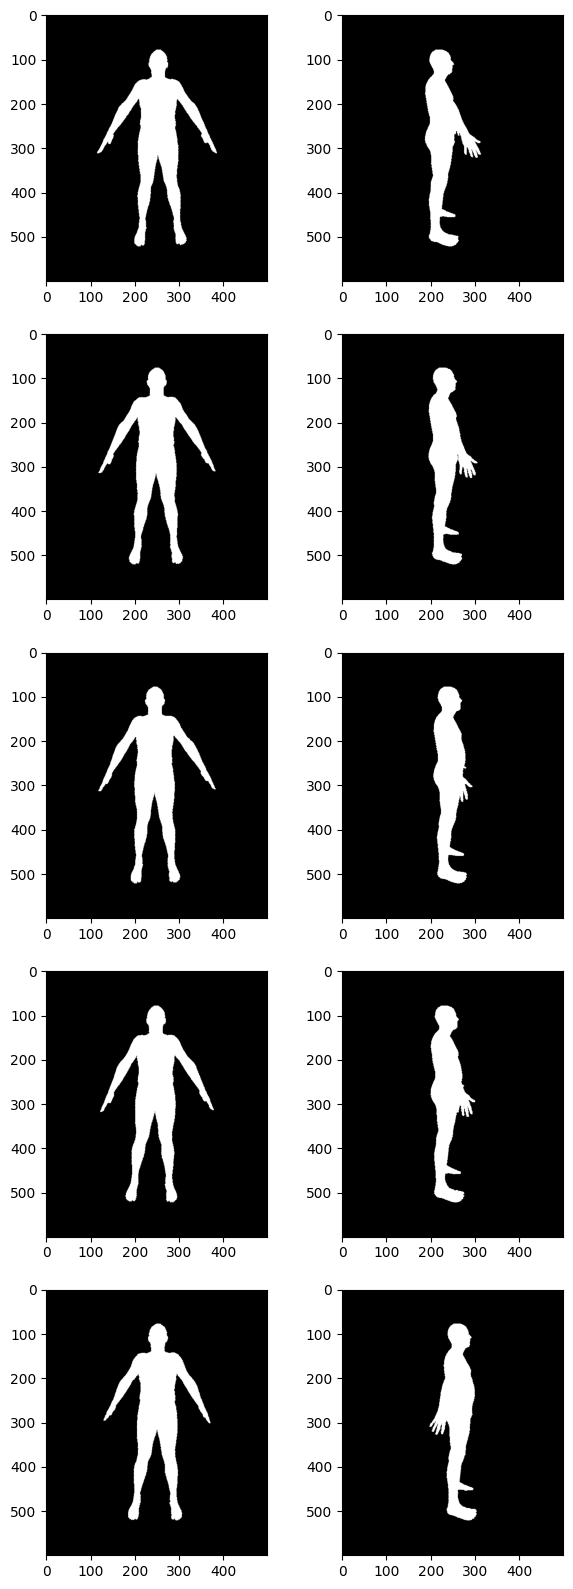

In [193]:
fig, axes = plt.subplots(5, 2, figsize=(7,20))

cam_distance = 1.8

for i, vertices in enumerate(v_meshs[:5]):
    vertices -= (v.min(axis=0) + v.max(axis=0))/2

    vertices_frontal = vertices.copy()
    vertices_lateral = vertices.copy()[:,(2,1,0)]

    vertices_frontal[:, 2] += cam_distance
    vertices_frontal[:, 2] = 2 * cam_distance  - vertices_frontal[:, 2]
    vertices_lateral[:, 2] += cam_distance

    frontal = pinhole(vertices_frontal)
    lateral = pinhole(vertices_lateral)
    
    f_img = make_silhouette(frontal, smpl_model.faces, 500, 600, 1.7, 2.30)
    axes[i, 0].imshow(f_img)

    l_img = make_silhouette(lateral, smpl_model.faces, 500, 600, 1.7, 2.30)
    axes[i, 1].imshow(l_img)

fig.show()

In [194]:
import os
import pickle

LABELING_CSV_PATH = '/workspace/RVH_Mesh_Registration/RVH_result_labeling.csv'
RVH_TEST = '/workspace/RVH_Mesh_Registration/data/rvh_test'

def get_label_names(csv_path):
    labeled_names = set()

    with open(csv_path, 'rt') as f:
        for l in f.readlines():
            l = l.strip()
            rvh_name, label, _ = l.split(',')

            if label == '1':
                labeled_names.add(rvh_name)

    return labeled_names

names = get_label_names(LABELING_CSV_PATH)

rvh_poses = []
for n in names:
    pkl_path = os.path.join(RVH_TEST, n, f'{n}E_m_smpl.pkl')
    with open(pkl_path, 'rb') as f:
       data = pickle.load(f)
    rvh_poses.append(data['pose']) 

rvh_poses = np.array(rvh_poses)

In [195]:
rvh_poses[:, 16 * 3 + 1], rvh_poses[:, 16 * 3 + 2], rvh_poses[:, 17 * 3 + 1], rvh_poses[:, 17 * 3 + 2]

(array([-0.6684363 , -0.28767225, -0.64163196, ..., -0.2764989 ,
        -0.24955001, -0.593306  ], dtype=float32),
 array([-1.4418032, -1.1207289, -1.3004537, ..., -1.1188835, -1.0165372,
        -1.2074118], dtype=float32),
 array([0.27195635, 0.18861352, 0.2951766 , ..., 0.13401571, 0.27408686,
        0.63750434], dtype=float32),
 array([1.2211605, 1.1360005, 1.3402904, ..., 1.0742923, 1.0252191,
        1.103349 ], dtype=float32))